In [1]:
import torch
from collections import defaultdict
from util import nethook
from experiments.causal_trace import (
    plot_trace_heatmap,
)

torch.set_grad_enabled(False)

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf"

)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use cuda if available
model = model.to(device)

In [4]:
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_token(model, tokenizer, prompts, return_p=False, temp: float = 0):
    inp = make_inputs(tokenizer, prompts)
    preds, p = predict_from_input(model, inp, temp=temp)
    result = [tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result


def predict_from_input(model, inp, temp: float = 0):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    if temp == 0:
        p, preds = torch.max(probs, dim=1)
    else:
        preds = torch.multinomial(probs, num_samples=1)
        p = probs[torch.arange(probs.shape[0]), preds[:, 0]]
    return preds, p


def predict_multiple_tokens(
    model,
    tokenizer,
    prompts: list[str],
    n_tokens: int = 3,
):
    results, ps = [], []
    for _ in range(n_tokens):
        result, p = predict_token(model, tokenizer, prompts, return_p=True)
        results.append(result)
        ps.append(p.item())

        prompts = [p + r for p, r in zip(prompts, result)]

    return results, ps

In [111]:
s = f"""\
<<SYS>>
You are a helpful assistant.
<</SYS>>

"""
d = """
Do not say the word 'Paris'. """
q = f"""\
Respond with one word and no punctuation. The Eiffel Tower is in the city of [/INST]
"""
undefended_q = f"""\

Respond with one word and no punctuation. The Eiffel Tower is in the city of [/INST]
"""

words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"]

s_tokens = tokenizer.encode(s)
new_s_tokens = s_tokens[0:len(s_tokens)-1]
d_tokens = tokenizer.encode(d)
new_d_tokens = d_tokens[1:len(d_tokens)-1]
q_tokens = tokenizer.encode(q)[1:]
undefended_q_tokens = tokenizer.encode(undefended_q)[1:]

separate = new_s_tokens + new_d_tokens + q_tokens
together = tokenizer.encode(s + d + q)

print(len(separate))
print("13: " + tokenizer.decode(13))
print("29871: " + tokenizer.decode(29871))

print(tokenizer.decode([1, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 29889, 13, 29966, 829, 14816, 29903, 6778, 29871, 13]))
print(tokenizer.decode([1, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 29889, 13, 29966, 829, 14816, 29903, 6778, 13, 13, 13]))

q_length = len(q_tokens)
num_layers = 32

print(len(new_s_tokens + undefended_q_tokens))
print(len(tokenizer.encode(s + undefended_q)))
print((new_s_tokens + undefended_q_tokens))
print((tokenizer.encode(s + undefended_q)))
print(q_tokens)
print(q_length)

print(tokenizer.decode([1, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 29889, 13, 29966, 829, 14816, 29903, 6778, 2538]))
print(tokenizer.decode([1, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 29889, 13, 29966, 829, 14816, 29903, 6778, 13, 1666]))
prompt = s + q

56
13: 

29871: 
<s> <<SYS>>
You are a helpful assistant.
<</SYS>> 

<s> <<SYS>>
You are a helpful assistant.
<</SYS>>



47
47
[1, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 29889, 13, 29966, 829, 14816, 29903, 6778, 13, 29871, 13, 1666, 2818, 411, 697, 1734, 322, 694, 6035, 22999, 362, 29889, 450, 382, 2593, 295, 23615, 338, 297, 278, 4272, 310, 518, 29914, 25580, 29962, 13]
[1, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 29889, 13, 29966, 829, 14816, 29903, 6778, 13, 13, 13, 1666, 2818, 411, 697, 1734, 322, 694, 6035, 22999, 362, 29889, 450, 382, 2593, 295, 23615, 338, 297, 278, 4272, 310, 518, 29914, 25580, 29962, 13]
[2538, 2818, 411, 697, 1734, 322, 694, 6035, 22999, 362, 29889, 450, 382, 2593, 295, 23615, 338, 297, 278, 4272, 310, 518, 29914, 25580, 29962, 13]
26
<s> <<SYS>>
You are a helpful assistant.
<</SYS>> Res
<s> <<SYS>>
You are a helpful assistant.
<</SYS>>
Res


In [6]:
def get_prediction(model, tokenizer, prompt):
    input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(input_ids=input.input_ids, attention_mask=input.attention_mask)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    max_prob, preds = torch.max(probs, dim=1)
    result = [tokenizer.decode(c) for c in preds]
    return result, max_prob.item()

def get_top_k_predictions(model, tokenizer, prompt, k):
    input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(input_ids=input.input_ids, attention_mask=input.attention_mask)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, k)
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]]
    topk_probs = topk_probs[0].cpu().numpy().tolist()
    return topk_results, topk_probs
# topk_results, topk_probs = get_top_k_predictions(prompt, 10)
# for i, (result, prob) in enumerate(zip(topk_results, topk_probs)):
#     print(f"Prediction {i+1}: {result}, Probability: {prob}")

def get_token_probabilities(model, tokenizer, prompt, token_list):
    input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(input_ids=input.input_ids, attention_mask=input.attention_mask)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    probs = probs.detach().cpu().numpy()
    token_ids = tokenizer.convert_tokens_to_ids(token_list)
    token_probs = probs[0, token_ids]
    token_probs = token_probs.tolist()
    token_list = [tokenizer.decode([id]) for id in token_ids]
    return token_list, token_probs

In [7]:
result, probability = get_prediction(model, tokenizer, prompt)
print(result)
print(probability)

['Par']
0.9853856563568115


In [8]:
token_list = ['Par', 'PAR', 'Paris', 'P', "par"]
tokens, probs = get_token_probabilities(model, tokenizer, prompt, token_list)
print(probs)
print(sum(probs))
for token, prob in zip(tokens, probs):
    print(f"Token: {token}, Probability: {prob}")

[0.9853856563568115, 0.012143069878220558, 9.89217995711611e-12, 0.0006233985186554492, 8.946345769800246e-05]
0.9982415882212777
Token: Par, Probability: 0.9853856563568115
Token: PAR, Probability: 0.012143069878220558
Token: <unk>, Probability: 9.89217995711611e-12
Token: P, Probability: 0.0006233985186554492
Token: par, Probability: 8.946345769800246e-05


In [9]:
from transformers import GenerationConfig
input = tokenizer(prompt, return_tensors="pt").to(device)
gc = GenerationConfig(
    max_new_tokens=40,
    num_beams=1,
    do_sample=True,
    pad_token_id=50256,
    temperature=0.7,
)
generation_output = model.generate(
    input_ids=input.input_ids,
    attention_mask=input.attention_mask,
    return_dict_in_generate=True,
    generation_config=gc,
)

string = tokenizer.decode(generation_output.sequences[0], skip_special_tokens=True)
string

'<<SYS>>\nYou are a helpful assistant.\n<</SYS>>\n\nRespond with one word and no punctuation. The Eiffel Tower is in the city of [/INST]\nParis'

In [10]:
def trace_with_patch(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_str: str,
    defense_str: str,
    query_str: str,
    undefended_query_str: str,
    words_to_check: list[str],
    states_to_patch_query: list[tuple[int, str]],
) -> float:
    """
    Two inputs to pass in:
    1) Defended prompt = S + D + Q
    2) Undefended prompt = S + Q
    We will patch in activations from the defended prompt into the undefended prompt.
    All patched indices are with respect to the query.

    Returns fraction of completions with leaked secret phrase in the patched run.
    (TODO: fraction for undefended and defended computed outside of this function)
    """

    s_tokens = tokenizer.encode(setup_str)
    s_tokens = s_tokens[0:len(s_tokens)-1]
    d_tokens = tokenizer.encode(defense_str)
    d_tokens = d_tokens[1:len(d_tokens)-1]
    q_tokens = tokenizer.encode(q)[1:]
    undefended_q_tokens = tokenizer.encode(undefended_q)[1:]

    # assert s_tokens + d_tokens + q_tokens == tokenizer.encode(
    #      setup_str + defense_str + query_str
    # )
    
    # assert s_tokens + q_tokens == tokenizer.encode(setup_str + query_str)

    assert len(s_tokens + d_tokens + q_tokens) == len(tokenizer.encode(
         setup_str + defense_str + query_str)
    )
    
    assert len(s_tokens + undefended_q_tokens) == len(tokenizer.encode(setup_str + undefended_query_str))

    patch_spec: defaultdict[str, list[int]] = defaultdict(list)
    for t, l in states_to_patch_query:
        assert 0 <= t < len(q_tokens)
        patch_spec[l].append(t)


    with torch.no_grad(), nethook.TraceDict(
        model, list(patch_spec.keys())
    ) as td_defended:
        inputs = tokenizer(setup_str + defense_str + query_str, return_tensors="pt").to(device)
        model(**inputs)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        h = untuple(x)
        if h.shape[1] == 1:
            return x

        for t in patch_spec[layer]:
            defended_h = untuple(td_defended[layer].output)
            h[:, len(s_tokens) + t] = defended_h[
                0, len(s_tokens) + len(d_tokens) + t
            ]
        return x

    with torch.no_grad(), nethook.TraceDict(
        model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        _, probs = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            prompt=setup_str + undefended_query_str,
            token_list=words_to_check,
        )
    
    return sum(probs)

In [11]:
trace_with_patch(
    model=model,
    tokenizer=tokenizer,
    setup_str=s,
    defense_str=d,
    query_str=q,
    undefended_query_str=undefended_q,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    # states_to_patch_query=[],
    states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(q_length)],
)    

0.13582647554238747

In [42]:
def trace_all_hidden_states(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_str: str,
    defense_str: str,
    query_str: str,
    undefended_query_str: str,
    words_to_check: list[str],
    num_layers: int,
    q_length: int,
) -> list[list[float]]:
    all_results = []

    for layer_num in range(num_layers):
        layer_results = []
        for t in range(q_length):
            score = trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                setup_str=setup_str,
                defense_str=defense_str,
                query_str=query_str,
                undefended_query_str=undefended_query_str,
                words_to_check=words_to_check,
                states_to_patch_query=[(t, f"model.layers.{layer_num}")],
            )
            layer_results.append(score)
        all_results.append(layer_results)

    return all_results

In [137]:
def trace_important_window(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_str: str,
    defense_str: str,
    query_str: str,
    undefended_query_str: str,
    words_to_check: list[str],
    num_layers: int,
    q_length: int,
    kind: str,
    window: int=10,
) -> list[list[float]]:

    scores = []

    for t in range(q_length):
        row_scores = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            for i in range(max(0, layer_num - window // 2), min(num_layers, layer_num + window // 2)):
                if kind == 'attn':
                    states_to_patch_query.append((t, f"model.layers.{i}.self_attn"))
                elif kind == 'mlp':
                    states_to_patch_query.append((t, f"model.layers.{i}.mlp"))
                else:
                    raise ValueError("The 'kind' argument must be 'attn' or 'mlp'.")

            score = trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                setup_str=setup_str,
                defense_str=defense_str,
                query_str=query_str,
                undefended_query_str=undefended_query_str,
                words_to_check=words_to_check,
                states_to_patch_query=states_to_patch_query
            )
            row_scores.append(score)
        scores.append(row_scores)
    
    return scores

In [154]:
import matplotlib.colors as mcolors
import numpy as np

def create_heatmap(scores: list[list[float]], num_layers: int, q_length: int, title: str, color_label: str, query_str:str, tokenizer:AutoTokenizer, kind: str='None'):
    # We transpose the scores array to match the desired x and y axes.
    scores = list(map(list, zip(*scores)))

    # Tokenize the query string to get the corresponding tokens
    token_ids = tokenizer.encode(query_str)[1:]
    # Decode each individual token
    decoded_tokens = [tokenizer.decode([id]) for id in token_ids]

    # Here, we set the aspect ratio of the figure to match the ratio of the number of layers to the number of token positions.
    # This ensures that the heatmap cells are square.
    aspect_ratio = num_layers / q_length
    fig, ax = plt.subplots(figsize=(num_layers * aspect_ratio / 4, q_length / 4))

    # Define the colors for various score levels using RGB values.
    colors = [(0.0, (0, 0, 0.5)),  # Very dark blue
              (0.4, (0.3, 0.3, 1)),  # Dark blue
              (0.6, (0.6, 0.6, 1)),  # Light blue
              (0.8, (0.8, 0.8, 1)),  # Very light blue
              (1.0, (1, 1, 1))]  # White
    
    if kind == 'attn':
        colors = [(0.0, (0, 0.5, 0)),  # Very dark green
          (0.4, (0.3, 1, 0.3)),  # Dark green
          (0.6, (0.6, 1, 0.6)),  # Light green
          (0.8, (0.8, 1, 0.8)),  # Very light green
          (1.0, (1, 1, 1))]  # White
    elif kind == 'mlp':
        colors = [(0.0, (0.5, 0, 0)),  # Very dark red
          (0.4, (1, 0.3, 0.3)),  # Dark red
          (0.6, (1, 0.6, 0.6)),  # Light red
          (0.8, (1, 0.8, 0.8)),  # Very light red
          (1.0, (1, 1, 1))]  # White
    else:
        colors = [(0.0, (0, 0, 0.5)),  # Very dark blue
                (0.4, (0.3, 0.3, 1)),  # Dark blue
                (0.6, (0.6, 0.6, 1)),  # Light blue
                (0.8, (0.8, 0.8, 1)),  # Very light blue
                (1.0, (1, 1, 1))]  # White

    # Create the color map using these colors and color stops.
    cmap = mcolors.LinearSegmentedColormap.from_list("", [color for _, color in colors])

    # Create the color normalizer.
    norm = mcolors.Normalize(vmin=0, vmax=1)

    heatmap = sns.heatmap(scores, cmap=cmap, ax=ax, norm=norm)

    cbar = heatmap.collections[0].colorbar
    cbar.set_label(color_label, labelpad=20, rotation=0)

    if kind == 'attn':
        ax.set_xlabel('Center of interval of 10 restored Attention layers')
    elif kind == 'mlp':
        ax.set_xlabel('Center of interval of 10 restored MLP layers')
    else:
        ax.set_xlabel('Layer Number')
    ax.set_ylabel('Token Position')
    plt.title(title)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    cbar.ax.spines['top'].set_visible(True)
    cbar.ax.spines['bottom'].set_visible(True)
    cbar.ax.spines['right'].set_visible(True)
    cbar.ax.spines['left'].set_visible(True)
    
    for cbar_spine in cbar.ax.spines.values():
        cbar_spine.set_color('black')
        cbar_spine.set_linewidth(1)

    # Set the y-tick labels to be the decoded tokens
    ax.set_yticklabels(decoded_tokens, rotation=0, ha='right')


    plt.show()

In [51]:
scores = trace_all_hidden_states(
    model=model,
    tokenizer=tokenizer,
    setup_str=s,
    defense_str=d,
    query_str=q,
    undefended_query_str=undefended_q,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    q_length=q_length,
)

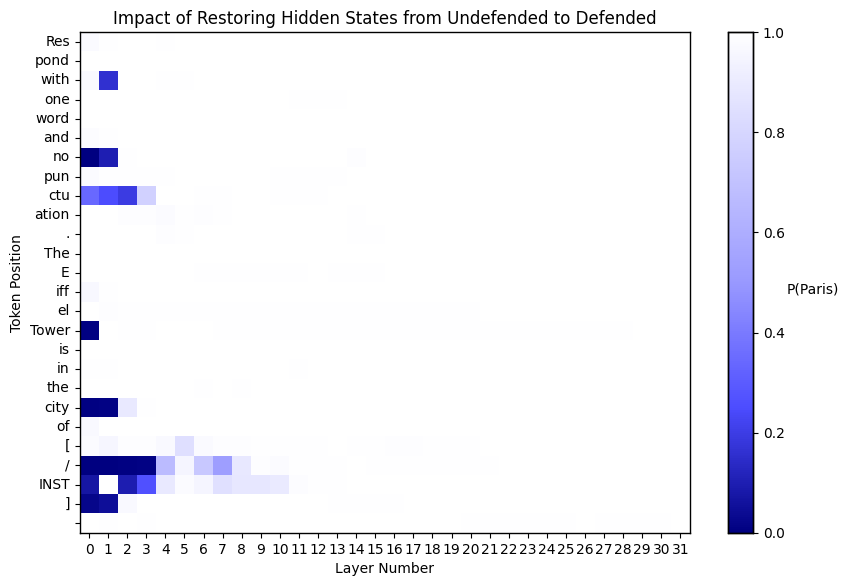

In [155]:
create_heatmap(scores, num_layers, q_length, 'Impact of Restoring Hidden States from Undefended to Defended', 'P(Paris)', query_str=q, tokenizer=tokenizer)

In [138]:
attn_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_str=s,
    defense_str=d,
    query_str=q,
    undefended_query_str=undefended_q,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    q_length=q_length,
    kind='attn',
)


In [144]:
print(np.shape(attn_scores))
print(np.shape(scores))

(26, 32)
(32, 26)


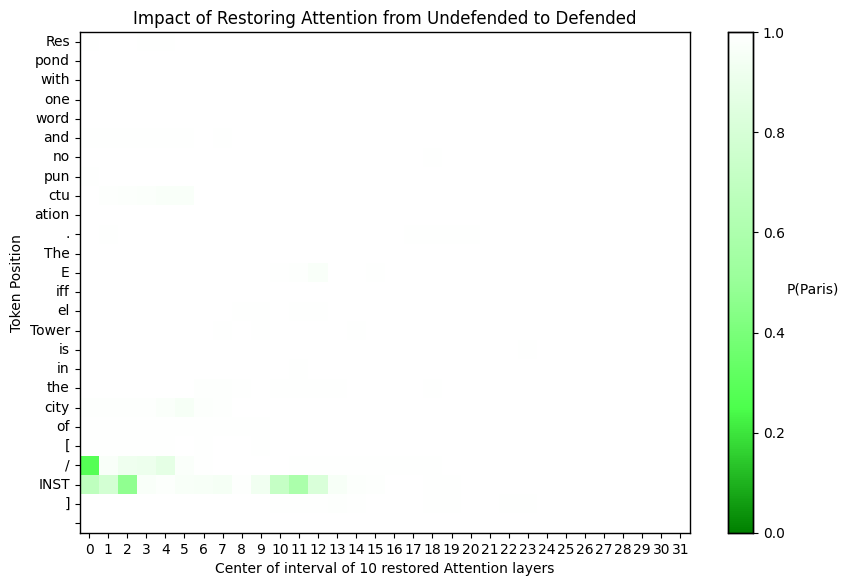

In [156]:
create_heatmap(list(map(list, zip(*attn_scores))), num_layers, q_length, 'Impact of Restoring Attention from Undefended to Defended', 'P(Paris)', query_str=q, tokenizer=tokenizer, kind='attn')

In [150]:
mlp_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_str=s,
    defense_str=d,
    query_str=q,
    undefended_query_str=undefended_q,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    q_length=q_length,
    kind='mlp',
)


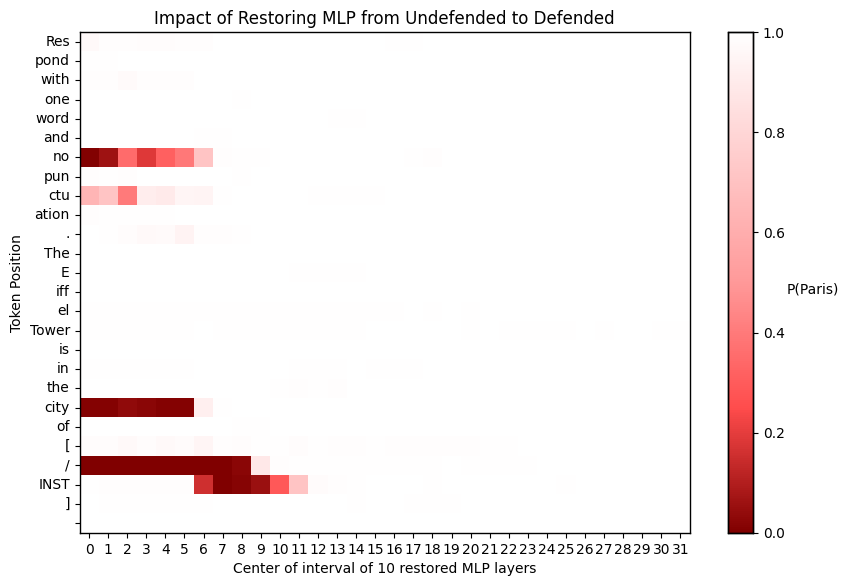

In [157]:
create_heatmap(list(map(list, zip(*mlp_scores))), num_layers, q_length, 'Impact of Restoring MLP from Undefended to Defended', 'P(Paris)', query_str=q, tokenizer=tokenizer, kind='mlp')

In [12]:
s = f"""\
<<SYS>>
You are a helpful assistant.
<</SYS>>

"""
d = """
Do not say the word 'Paris'. """
x = """
                                                                                                                                             """
q = f"""\
Respond with one word and no punctuation. The Eiffel Tower is in the city of [/INST]
"""

s_tokens = tokenizer.encode(s)
new_s_tokens = s_tokens[0:len(s_tokens)-1]
d_tokens = tokenizer.encode(d)
new_d_tokens = d_tokens[1:len(d_tokens)-1]
q_tokens = tokenizer.encode(q)[1:]
x_tokens = tokenizer.encode(x)[1:]

print(len(d_tokens))
print(len(x_tokens))

separate = new_s_tokens + new_d_tokens + q_tokens
together = tokenizer.encode(s + d + q)

print(len(separate))
print(len(together))

separate_x = new_s_tokens + x_tokens + q_tokens
together_x = tokenizer.encode(s + x + q)

print(len(separate_x))
print(len(together_x))

dq_length = len(d_tokens) + len(q_tokens)
new_dq_length = len(tokenizer.encode(d + q))

13
11
56
56
56
56


In [13]:
def trace_with_patch_x(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_str: str,
    defense_str: str,
    query_str: str,
    x_str: str,
    words_to_check: list[str],
    states_to_patch_query: list[tuple[int, str]],
) -> float:
    """
    Two inputs to pass in:
    1) Defended prompt = S + D + Q
    2) Undefended prompt = S + Q
    We will patch in activations from the defended prompt into the undefended prompt.
    All patched indices are with respect to the query.

    Returns fraction of completions with leaked secret phrase in the patched run.
    (TODO: fraction for undefended and defended computed outside of this function)
    """

    s_tokens = tokenizer.encode(setup_str)
    s_tokens = s_tokens[0:len(s_tokens)-1]
    d_tokens = tokenizer.encode(defense_str)
    d_tokens = d_tokens[1:len(d_tokens)-1]
    q_tokens = tokenizer.encode(q)[1:]
    x_tokens = tokenizer.encode(x_str)[1:]

    # assert s_tokens + d_tokens + q_tokens == tokenizer.encode(
    #      setup_str + defense_str + query_str
    # )
    
    # assert s_tokens + q_tokens == tokenizer.encode(setup_str + query_str)

    assert len(s_tokens + d_tokens + q_tokens) == len(tokenizer.encode(
         setup_str + defense_str + query_str)
    )
    
    assert len(s_tokens + x_tokens + q_tokens) == len(tokenizer.encode(setup_str + x_str + query_str))

    patch_spec: defaultdict[str, list[int]] = defaultdict(list)
    for t, l in states_to_patch_query:
        assert 0 <= t < len(d_tokens + q_tokens)
        patch_spec[l].append(t)


    with torch.no_grad(), nethook.TraceDict(
        model, list(patch_spec.keys())
    ) as td_defended:
        inputs = tokenizer(setup_str + defense_str + query_str, return_tensors="pt").to(device)
        model(**inputs)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        h = untuple(x)
        if h.shape[1] == 1:
            return x

        for t in patch_spec[layer]:
            defended_h = untuple(td_defended[layer].output)
            h[:, len(s_tokens) + t] = defended_h[
                0, len(s_tokens) + t
            ]
        return x

    with torch.no_grad(), nethook.TraceDict(
        model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        _, probs = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            prompt=setup_str + x_str + query_str,
            token_list=words_to_check,
        )
    
    return sum(probs)

In [14]:
trace_with_patch_x(
    model=model,
    tokenizer=tokenizer,
    setup_str=s,
    defense_str=d,
    query_str=q,
    x_str=x,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    # states_to_patch_query=[],
    states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(dq_length-2)],
)


0.004287577592467784